Covid images


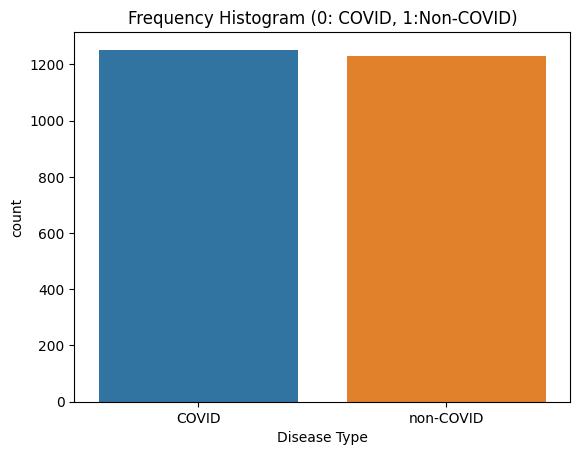

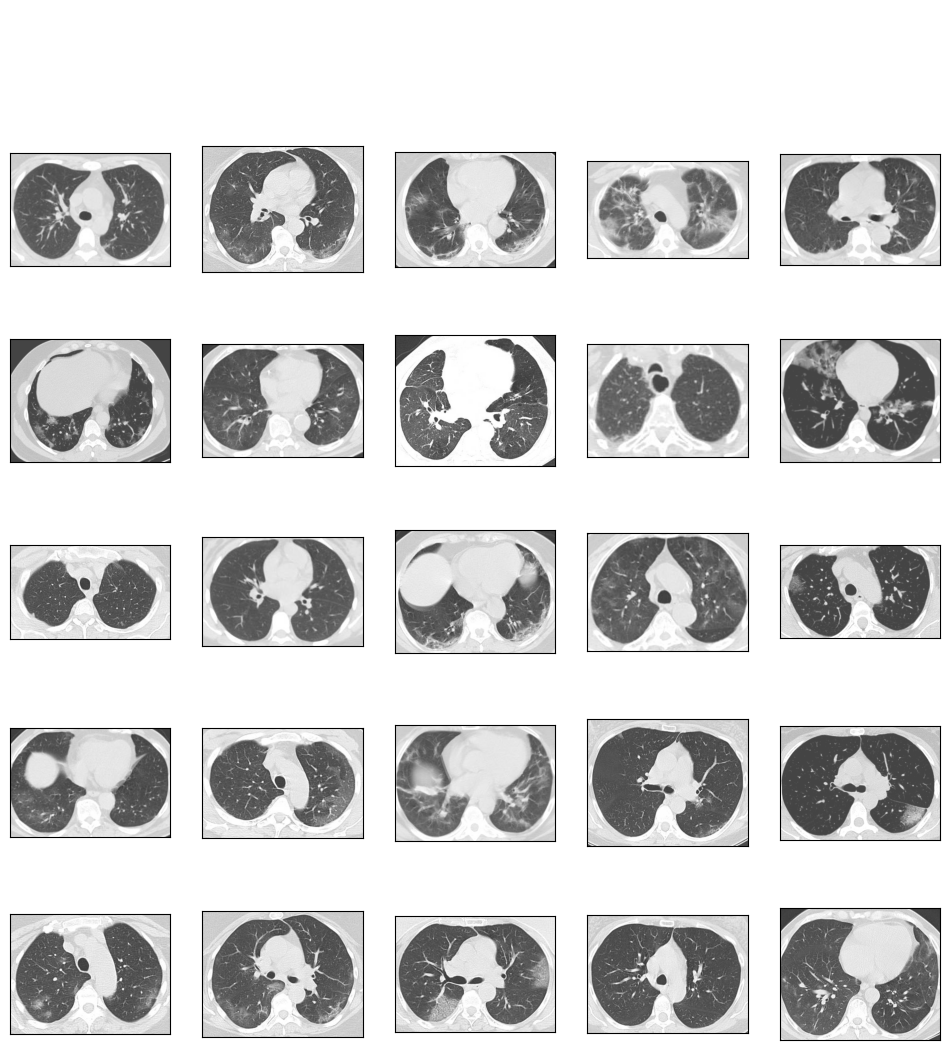

Non Covid Images


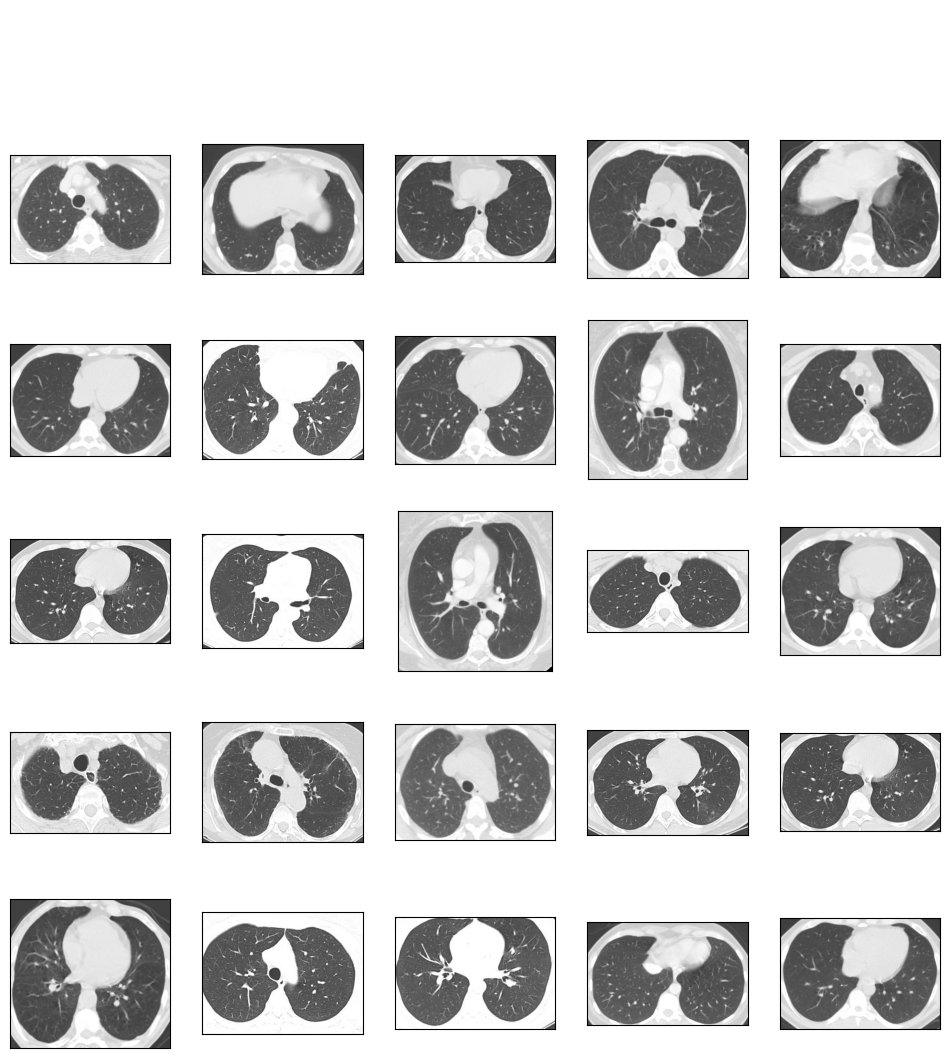

In [4]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Set random seed for reproducibility
Seed = 40
np.random.seed(Seed)
tf.random.set_seed(Seed)

# Define disease types
disease_types = ['COVID', 'non-COVID']

# Define data directory
data_dir = '/content/drive/MyDrive/Desertation/CTSCAN'
# Read and preprocess data
train_data = []
for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns=['File', 'ID', 'Disease Type'])

# Shuffle the data
train = train.sample(frac=1, replace=False, random_state=Seed).reset_index(drop=True)

# Display the distribution of classes
sns.countplot(x="Disease Type", data=train)
plt.title("Frequency Histogram (0: COVID, 1:Non-COVID)")
#plt.show()

# Function to plot sample images for each class
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values

    fig.suptitle(defect_types, fontsize=22, color="white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[i * cols + j])
            image = cv2.imread(image_path)
            ax[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.show()

# Display sample images for each class
print('Covid images')
plot_defects('COVID', 5, 5)
print('Non Covid Images')
plot_defects('non-COVID', 5, 5)

# Constants for image processing
IMAGE_SIZE = 224
channels = 3

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

# Prepare the data
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_train = X_train / 255.0  # Pixel normalization

Y_train = to_categorical(train['ID'].values, num_classes=2)

# Split the data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                                  Y_train,
                                                  test_size=0.2,
                                                  random_state=Seed)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0     

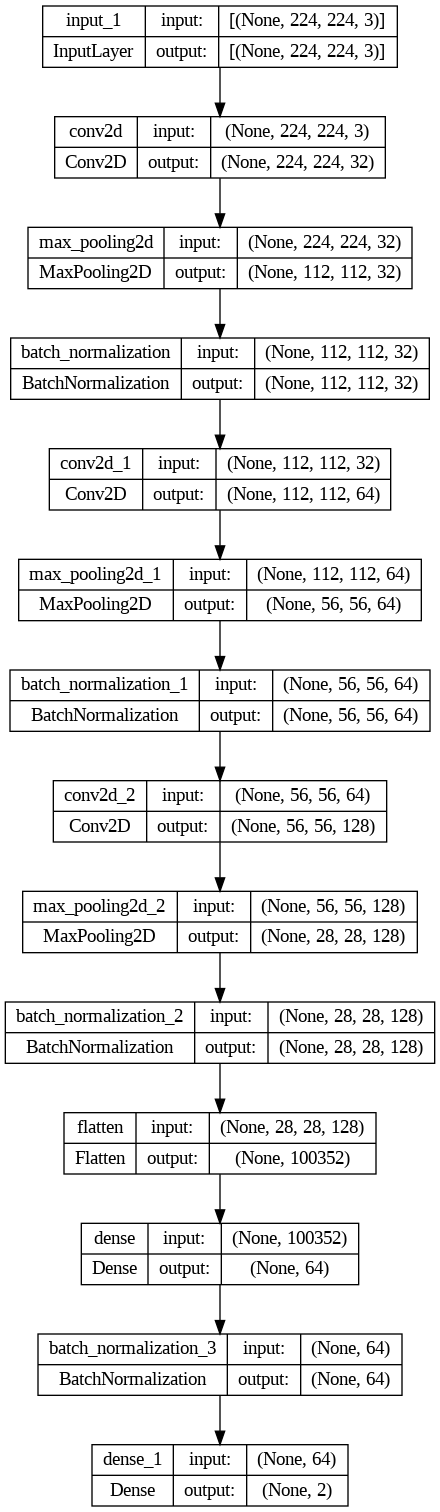

In [5]:
# Build your own custom CNN model
def build_custom_model(image_size, channels):
    inputs = Input(shape=(image_size, image_size, channels))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

# Build your own custom CNN model
model = build_custom_model(IMAGE_SIZE, channels)

# Define the callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the model with augmented images
datagen.fit(X_train)
start_time = time.time()

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] // 32,
    epochs=1,
    verbose=1,
    callbacks=[annealer, checkpoint],
    validation_data=(X_val, Y_val)
)

# Save the model architecture as a plot
tf.keras.utils.plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)

In [6]:
Y_pred = model.predict(X_val)
end_time = time.time()
total_time = end_time - start_time
frame_rate = len(X_val) / total_time

print(f"Frame Rate: {frame_rate:.2f} samples/s")



16/16 [==============================] - 0s 10ms/step
Frame Rate: 2.28 samples/s


In [ ]:
IMAGE_SIZE = 224
channels = 3
from tensorflow.keras.regularizers import l2
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.003
    if epoch < 30:
        return initial_lr
    elif epoch < 60:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

lr_scheduler = LearningRateScheduler(lr_schedule)

# Build your own custom CNN model
def build_custom_model(image_size, channels):
  inputs = Input(shape=(image_size, image_size, channels))

  x = Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01))(inputs)
  x = BatchNormalization()(x)
  x = MaxPool2D()(x)
  x = Dropout(0.3)(x)

  x = Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01))(x)
  x = BatchNormalization()(x)
  x = MaxPool2D()(x)
  x = Dropout(0.3)(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  outputs = Dense(2, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)
  optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model.summary()
  return model

# Build your own custom CNN model
model = build_custom_model(IMAGE_SIZE, channels)

# Define the callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the model with augmented images
datagen.fit(X_train)

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] // 32,
    epochs=100,
    verbose=1,
    callbacks=[annealer, checkpoint],
    validation_data=(X_val, Y_val)
)

# Save the model architecture as a plot
tf.keras.utils.plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
